# Chapter 13 - Loading and Preprocessing Data with TensorFlow

In [1]:
%autosave 120

import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(24)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Autosaving every 120 seconds


So far we've only used datasets that fit in memory - but deep learning often train on very large datasets that won't fit into RAM. TF makes it easy to ingest a large dataset - the Data API - can just create dataset object, tell it where to get data, and transform it however you want. TF takes care of all the implementation details - multithreading, queuing, batching, prefetching and so on.

Data API can read text files, binary files, SQL etc. TFRecord is a flexible/efficient binary format.

Reading huge datasets isn't the only difficulty - data also needs to be preprocessed - sometimes there is text features, categorical features, and so on. TF then has the Features API - easily converting these features to numerical features consumed by the network. Large categorical features can be encoded using embeddings. 

This chapter covers the Data API, TFRecord and the Features API.


# The Data API

Data API revolves around the concept of datasets - sequence of data items. Now lets create a dataset entirely in RAM:

In [2]:
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
# takign a tensor and creating a dataset whose elements are all the slices of X
# this case its just tensors 0, 1, 2...9

print(dataset)
for item in dataset:
    print(item)

<TensorSliceDataset shapes: (), types: tf.int32>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [3]:
# Chaining Transformations - apply transformation methods, each time returning a new dataset

dataset = dataset.repeat(3).batch(7)
for item in dataset: 
    print(item)
    
# First repeating the 0~9 dataset 3 times, and then grouping it in batches of 7 items

# Datasets are not modified - new ones are created - always keep a reference to these new datasets

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [4]:
# Map transforms each item - can set num_parallel_calls if wanting to spawn multiple threads

dataset = dataset.map(lambda x: x*2) # Items: [0, 2, 4, 6, 8, 10, 12]


# Apply transforms entire dataset

dataset = dataset.apply(tf.data.experimental.unbatch())


dataset = dataset.filter(lambda x: x < 10)


for item in dataset.take(3):
    print(item)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


2021-08-18 12:46:23.527727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-18 12:46:23.528221: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


## Shuffling Data

Gradient Descent works best when training set instances are independent and identically distributed. One can shuffle the instances - use shuffle().  This creates a new dataset which fills up a buffer with the first items of the source dataset; when asked for an item, it will pull out randomly and replace it with a fresh one from the source dataset until iterating through the source dataset. 

Basically - random order. Decided through seed

Important to make buffer large or shuffling won't be very efficient. 

In [5]:
dataset = tf.data.Dataset.range(10).repeat(3)

dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)

for item in dataset:
    print(item)
    

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


In [6]:
# The above might not be enough - better to also shuffle the source code

# Interleaving Lines from multiple files - simutaneously read multiple files at once
# Start by loading/preping the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target.reshape(-1, 1),
                                                              random_state=24)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=24)

scaler = StandardScaler()
scaler.fit(X_train)

X_mean = scaler.mean_
X_std = scaler.scale_


In [7]:
# For large datasets that don't fit into memory - split into many files first, and then have TF read them in parallel

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    filepaths = []
    m = len(data)
    
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, 'wt', encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths 

In [8]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

# Now they are all saved - inside datasets->housing

In [9]:
# The first file - my_train_00

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,6.2242,13.0,6.121321,0.979182,4597.0,3.300072,33.65,-117.66,2.379
1,2.3450,38.0,2.383333,0.940000,1174.0,3.913333,34.06,-118.26,2.250
2,3.6429,42.0,5.246628,1.115607,1419.0,2.734104,37.78,-122.49,3.284
3,5.7068,9.0,5.861561,1.083947,1705.0,2.511046,37.70,-121.76,2.567
4,3.2115,37.0,4.136519,1.037543,1076.0,3.672355,33.78,-118.28,1.601


In [10]:
# Text mode

with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
6.2242,13.0,6.121320890165111,0.9791816223977028,4597.0,3.3000717875089736,33.65,-117.66,2.379
2.345,38.0,2.3833333333333333,0.94,1174.0,3.9133333333333336,34.06,-118.26,2.25
3.6429,42.0,5.246628131021194,1.115606936416185,1419.0,2.7341040462427744,37.78,-122.49,3.284
5.7068,9.0,5.861561119293078,1.0839469808541973,1705.0,2.5110456553755522,37.7,-121.76,2.567


In [11]:
# Dataset

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=24) # Returns shuffled dataset

n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

# Interleave creates a dataset pulling 5 file paths from the dataset, calling the function for each one 
# to create a new dataset. 


# Can use num_parallel_calls to read in parallel

for line in dataset.take(5):
    print(line.numpy())


b'6.2242,13.0,6.121320890165111,0.9791816223977028,4597.0,3.3000717875089736,33.65,-117.66,2.379'
b'1.1111,19.0,5.830917874396135,1.173913043478261,721.0,3.4830917874396135,37.81,-122.28,1.083'
b'2.6458,35.0,5.319444444444445,1.2777777777777777,202.0,2.8055555555555554,40.02,-120.92,1.025'
b'10.3894,32.0,7.320833333333334,0.9854166666666667,1583.0,3.2979166666666666,37.4,-122.12,5.00001'
b'3.48,26.0,5.610619469026549,1.0123893805309734,1524.0,2.697345132743363,37.31,-120.46,0.953'


In [12]:
# Preprocrssing the data

# X_mean, X_std = [...] assuming precomputation of mean and standard deviation of each feautre - just 1D tensors
n_inputs = 8

def preprocess(line): # takes a CSV fils
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs) 
    # parses the line - all feature columns are floats, and missing default to 0
    
    # decode_csv returns list of scalar tensors - so we call tf.stack to turn them into 1D arrays - except last one
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return(x - X_mean) / X_std, y
    # scaling by subtracting the feature means and dividing by SD

In [13]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.17044412,  1.2110956 , -0.04262504, -0.33371976, -0.49463364,
        -0.06163128,  0.8615548 , -1.3111265 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting everything together - pipeline

Organising into small helper function - creating/returning datasets to efficiently load California housing data from mutiple CSV files, shuffle it, preprocess and batch.

<div>
    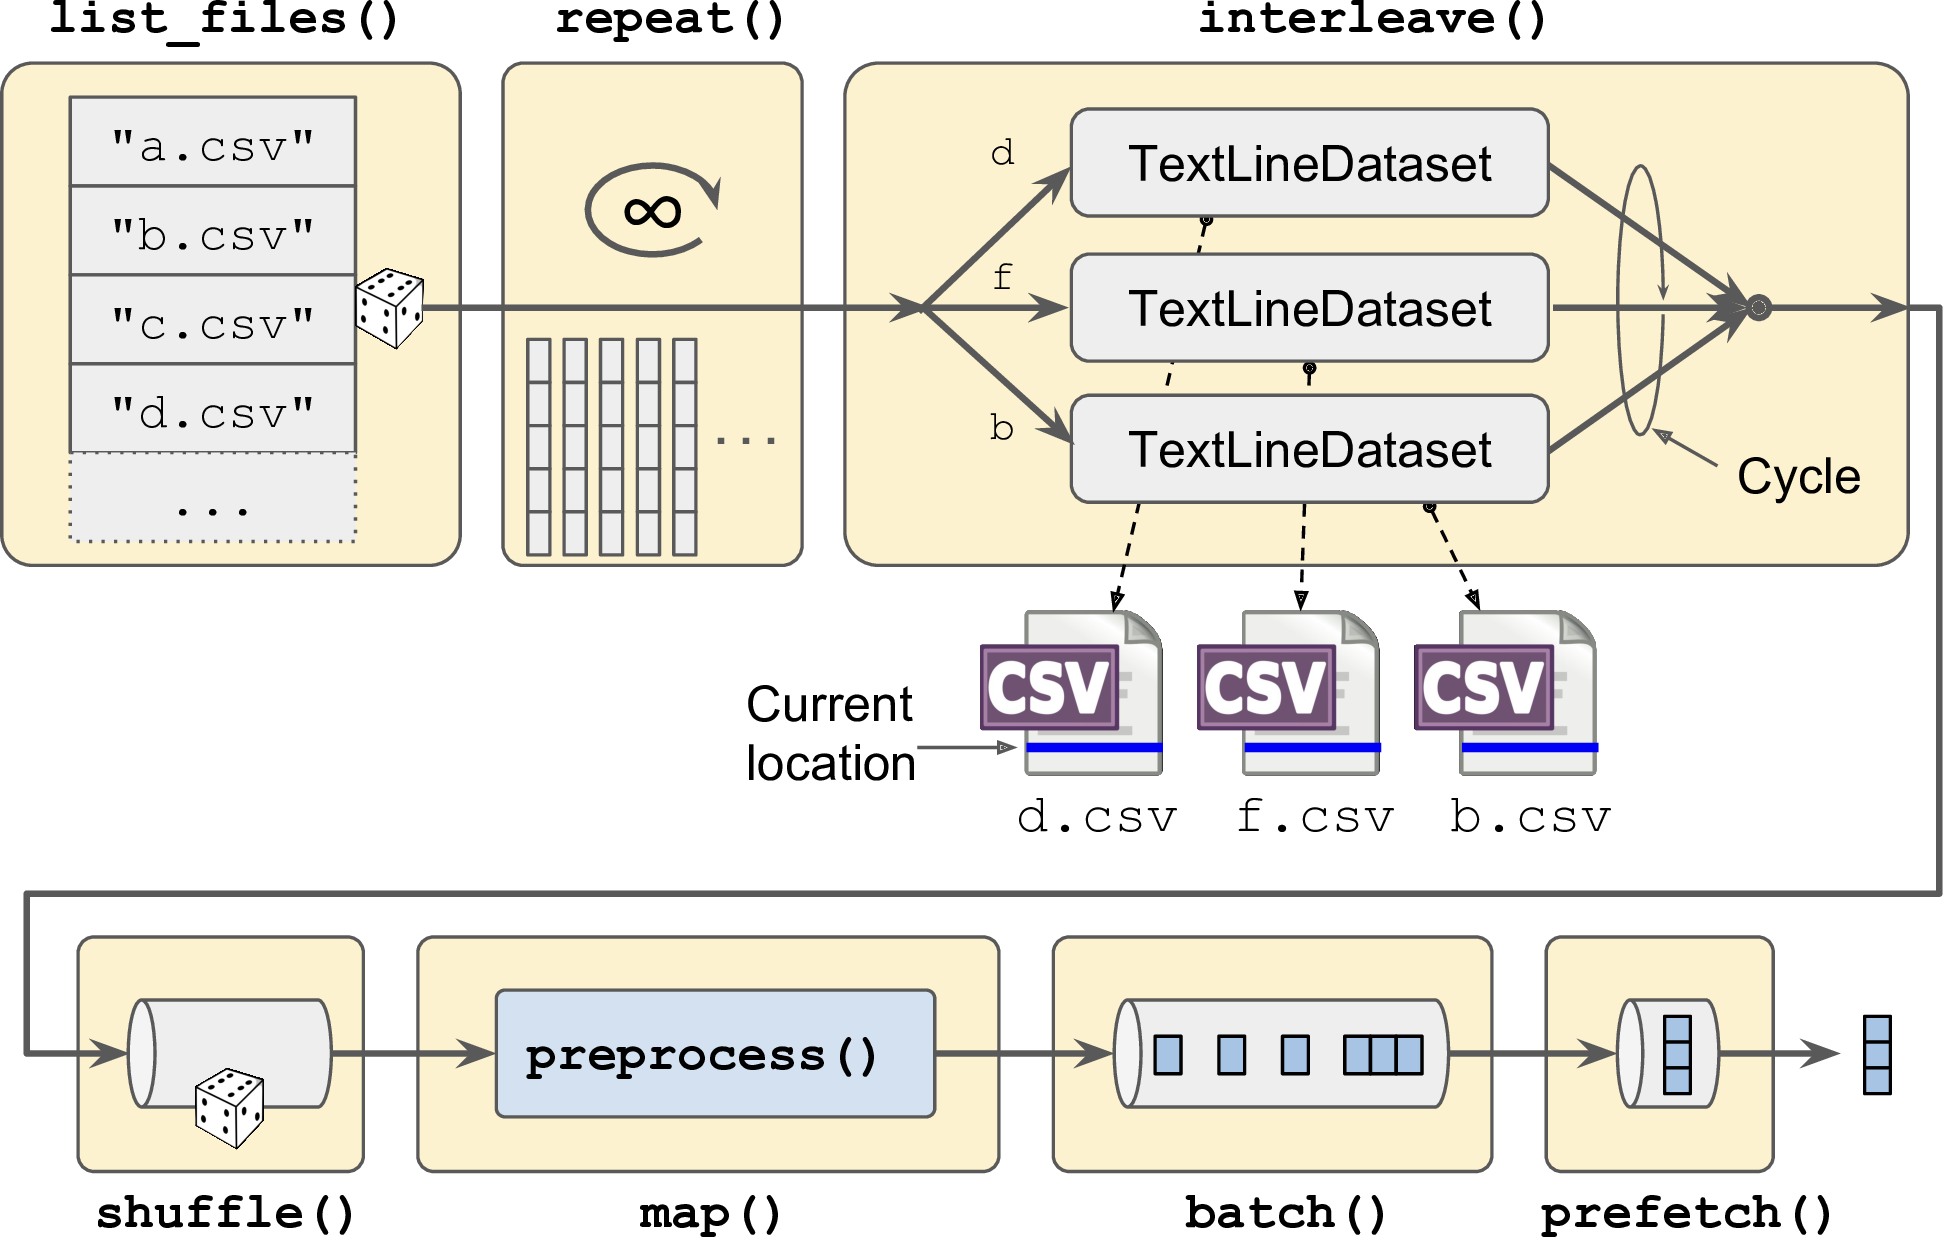
</div>

In [14]:
def csv_reader_dataset(filepaths, repeat=None, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    
    dataset = tf.data.Dataset.list_files(filepaths).skip(1)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                cycle_length=n_readers, num_parallel_calls=n_read_threads)
    
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(1)

## Prefetching

we are creating a dataset to always be one batch ahead - while training algorithm is working on 1 batch, dataset is working in parallel on getting the next batch ready. Improves performance dramatically.

If loading/preprocessing multithreaded, we can exploit the multiple CPU cores by preparing one batch shorter than running a training step on GPU - the GPU will then be 100% utilized - making training faster.

How it works:

<div>
    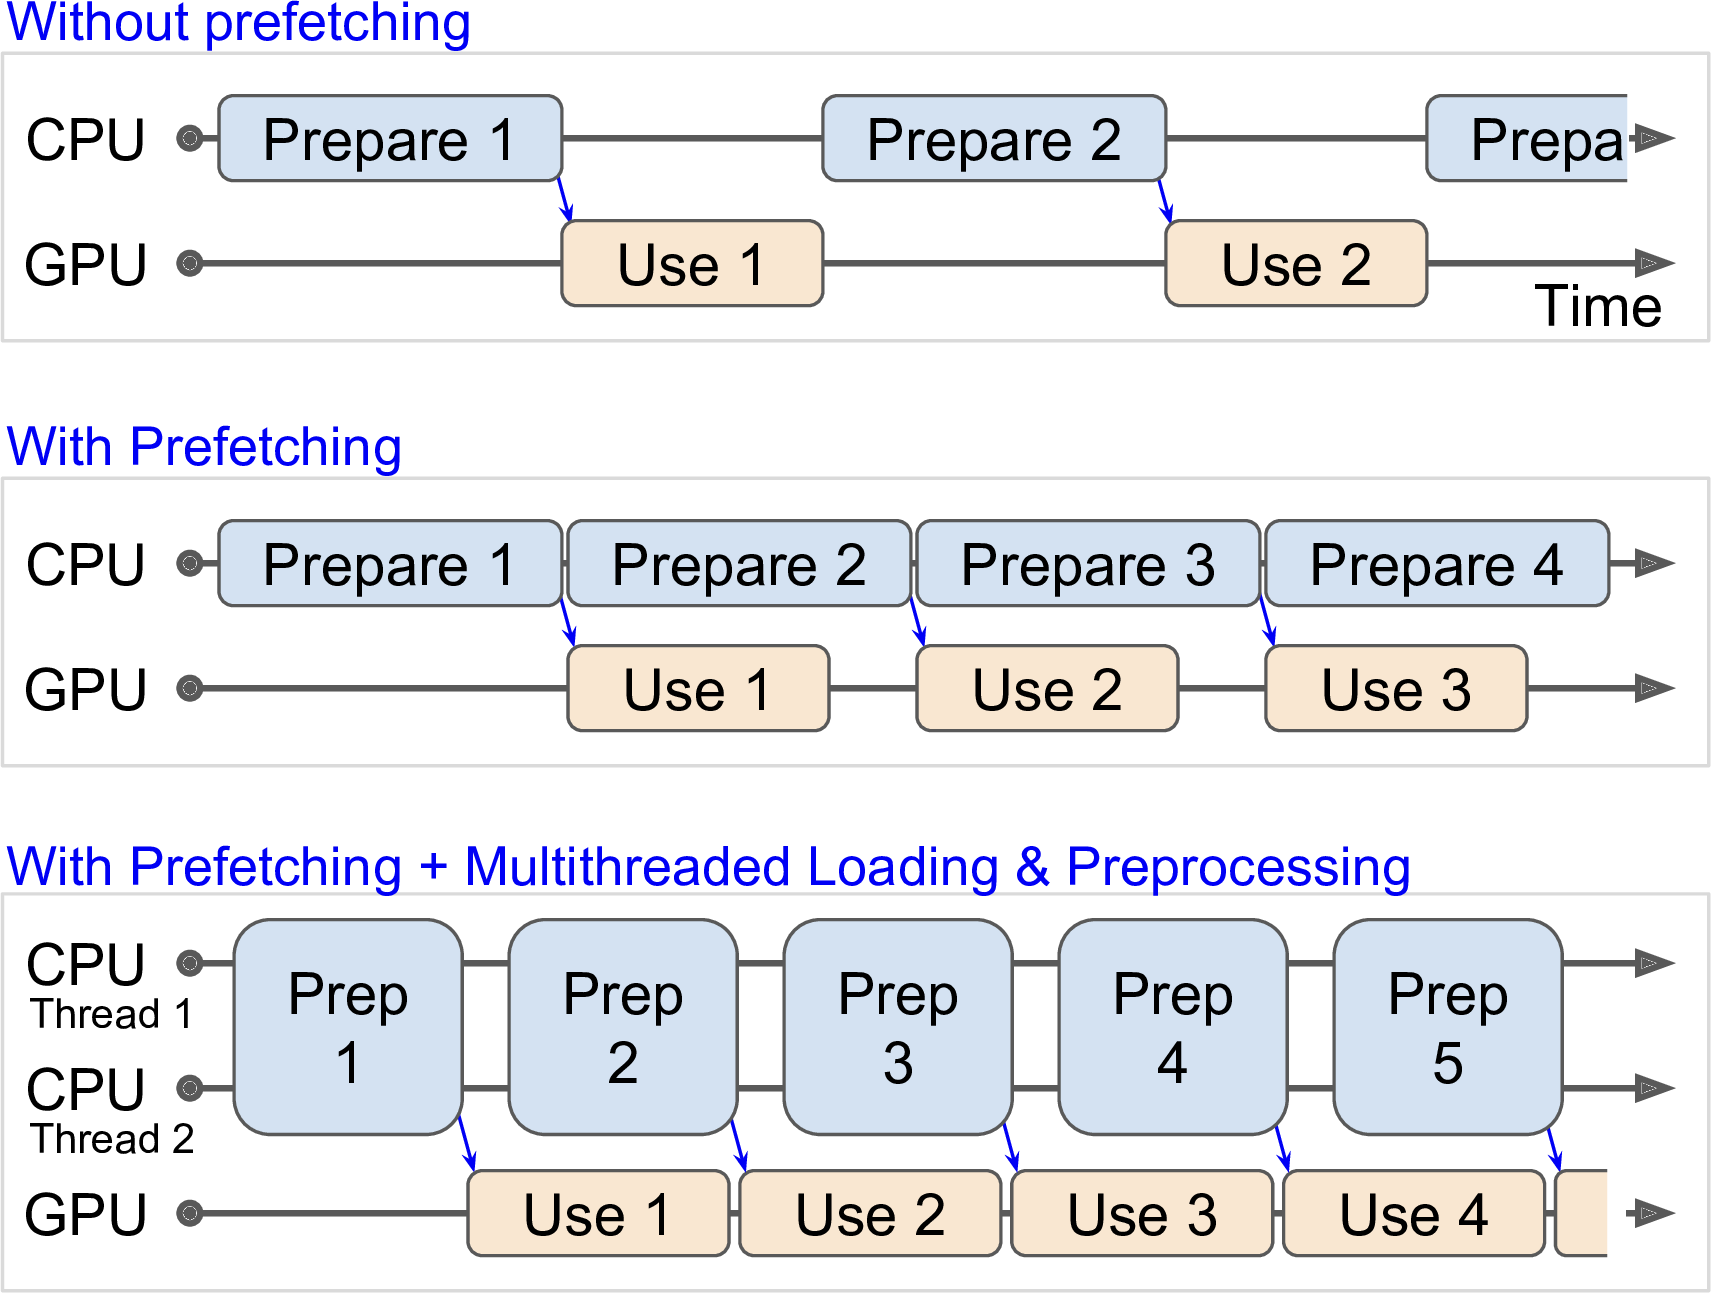
</div>


Few more techniques: concatenate, zip, window, reduce, cache, shard, flat_map, padded_batch. And class methods: from_generator, from_tensors - creating new dataset from Python generator. 



## Using the Dataset with tf.keras

In [15]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [16]:
keras.backend.clear_session()
np.random.seed(24)
tf.random.set_seed(24)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [17]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

batch_size = 32
model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 3.8292 - val_loss: 0.9295
Epoch 2/10
345/345 [==============================] - 0s 984us/step - loss: 0.8412 - val_loss: 0.7148
Epoch 3/10
345/345 [==============================] - 0s 1ms/step - loss: 0.6546 - val_loss: 0.6299

In [18]:
model.evaluate(test_set)

146/146 [==============================] - 0s 673us/step - loss: 0.5166


0.5166065692901611

In [19]:
# Creating a tf.function to preform the training loop

# COPIED - can't be bothered to even read through
@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

YEH - now can built input pipelines with Data API. We've only used CSV files - common simple and convenient - but not efficient and not supportive ot large/complex data structures. Learn to use TFRecord next. 

HOWEVER - no need to use TFRecords if happy with CSV. 

# The TFRecord Format

TF's preferred. Simple binary format with a sequence of binary records of varying sizes.

In [20]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b"First record")
    f.write(b"Second record")
    
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'First record', shape=(), dtype=string)
tf.Tensor(b'Second record', shape=(), dtype=string)


In [21]:
# Compressing - when loaded via network connection

options = tf.io.TFRecordOptions(compression_type="GZIP")

# with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f
# dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], compression_type="GZIP")

# Protocol Buffers

TFRecord files contain serialized protocol buffers - protobufs - a portable, extensible and efficient binary format.

Skipped the bits TF protobufs

In [22]:
# Cant use it now. Protobuf defintion is in a different language

from person_pb2 import Person

person = Person(name="AI", id=123, email=["a@b.com"])
print(person)

# Can't be used as they are not TF functions. But TF does have special protobuf definitions

ModuleNotFoundError: No module named 'person_pb2'

In [ ]:
# Loading/Parsing Examples

feature_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=""),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string)
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_exmaple(serialized_example, feature_description)

    
# ETCETC - basically skipped most of the TFRecords stuff due to not understanding/needing to use it 

# The Features API

Preprocessing - can do beforehand, or on the fly when loading with Data API, or a preprocessing layer in the neural net. Whichever solution, the features API can help - a set of functions letting you define how each feature in the data should be preprocessed  - analog of SKLearn's ColumnTransformer. 

In [ ]:
# Features API is in tf.feature_column

housing_median_age = tf.feature_column.numeric_column('housing_median_age') # can specify normalization function

age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column('housing_median_age',
                                                      normalizer_fn=lambda x: (x - age_mean) / age_std)


In [ ]:
# Transforming numerical feature to catagorical features - 5 buckets
# Choosing the buckets - percentiles of the data

median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(median_income, boundaries=[1.5, 3., 4.5, 6.])

In [ ]:
# Categorical Features

# If already represented by a category ID - use categorical_column_with_identity()

# If not:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list('ocean_proximity',
                                                                            ocean_prox_vocab)


# If category with vocabulary too large (ie. cities, zip codes, words etc) - use hash:
city_hash = tf.feature_column.categorical_column_with_hash_bucket('city',
                                                                  hash_bucket_size = 1000)
# Will compute hash for each category

In [ ]:
# Crossed Categorical Features

# When 2 features are more meaningful being used together
bucketized_age = tf.feature_column.bucketized_column(housing_median_age,
                                                     boundaries=[-1., -0.5, 0., 0.5, 1.]) # age scaled

age_and_ocean_proximity = tf.feature_column.crossed_column([bucketized_age, ocean_proximity],
                                                           hash_bucket_size=100)

In [ ]:
# Must encode the categorical feature before feeding to neural network - 2 options - one hot vectors, or embeddings

# One Hot Encoders
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
# Good when low vocabulary lengths


# <10 = one hot
# >50 = embeddings
# In between -> experiment with both



# Embeddings
# Embeddings are initizlied randomly and trainable - so get better during training. 
# Embeddings then become useful representations of the categories - representation learning

# EG. embeddings can be reused. In natural language processing for example - using a neural net in 2013
# Concepts of gender and capitols, etc. Close to what Jack was saying about Language Bias.

ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity, dimension=2)

# vectors are stored in an embedding matrix with one row per category and one column per embedding dimension

## Using Feature Columns for Parsing

After creating feature columns for each of the input features and the target, can then pass them to the make_parse_example_spec() function to generate feature descriptions.

columns = [... the features] <br>
feature_descriptions = tf.feature_clumn.make_parse_example_spec(columns)

In [ ]:
# Function to parse serialized examples

def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value")
    
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(['my_data_with_features.tfrecords'])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

## Using feature columns in your models

Can also be directly used to convert all input features into a single dense vector - add a DenseFeatures layer as the first layer - passing it the list of feature columns (except the target column)

In [ ]:
median_house_value = tf.feature_column.numeric_column("median_house_value")
columns = [housing_median_age, median_house_value]

dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)


columns_without_target = columns[:-1]


model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])

# DenseFeatures converts every input to a dense representation, as well as applying extra transformation

model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])
# steps_per_epoch = len(X_train) // batch_size
history = model.fit(dataset, epochs=5)

In [ ]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)

dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

# Resulting tensor is a concatenation of the one-hot vectors and the embeddings

# TF Transform

If preprocessing is computationally expensive, then handling it before training gives a significant speedup - data will be preprocessed once per instance before training.

Tools like Apache Beam let you run efficient data processing pipelines - but when employing on the web or app - need to write some preprocessing code. This way - very maintenance heavy - time consuming and error prone. 

One improvement - adding an extra input layer to take care of preprocessing on the fly. Better but still have to improve the Apache Beam code.

TF Transform - part of TensorFlow Extended - is an end to end platform for productionizing TF models. 

In [ ]:
# Have to install TFX first - https://www.tensorflow.org/tfx/serving/setup - its a server so quite complicated

import tensorflow_transform as tft


# Preprocessing with 2 features
def preprocess(inputs): # a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]

    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

Can then use preprocess with Apache Beam - computing all the necessary statistics. 

TF Transform will also generate an equivalent TF function that can be plugged into model to deploy. Contains all necessary stats computed by Apache Beam. 


With the Data API, TFRecords, Features API and TF Transform - can build highly scalable input pipelines for training - and benefit from fast/portable data preprocessing in production. 


# TensorFlow Datasets (TFDS) Project

Standard datasets. Making it trivial to download common datasets - see https://homl.info/tfds to view the whole list.

In [ ]:
import tensorflow_datasets as tfds

dataset = tfds.load(name="mnist") # Load already shuffles
mnist_train, mnist_test = dataset["train"], dataset["test"]



In [ ]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)

for item in mnist_train:
    images = item["image"]
    labels = item['label']
    
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
        
    break # part of the first batch

In [ ]:
# Each item in dataset is dictionary containing the features + labels. But Keras expects a tuple:
# Can to this with map(), or ask the load function (only works with labelled datasets)

dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)

mnist_train = dataset["train"].repeat().prefetch(1)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

model.fit(mnist_train, steps_per_epoch=60000//32, epochs=5)

Very technical chapter - far from the abstract beauty of neural nets - however, it's crucial to know how to load, parse, and preprocess data correctly, because of the amount of data involved in deep learning.